In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Copyright (C) 2021 Swiss Tropical and Public Health Institute

This malaria model is free software; you can redistribute it and/or modify it under the terms of version 2 of the GNU General Public License as published by the Free Software Foundation.

# Impact of human movement on malaria persistence in Zanzibar

A study conducted in Zanzibar to examine reactive case detection highlighted that many of the index cases may have been imported from the mainland. Similarly, the probability of a non-index traveller testing positive for malaria was higher if they had travelled in th`e past 60 days, though this result was not statistically significant ([Stuck et al. 2020](https://www.sciencedirect.com/science/article/pii/S1201971220304525)). Further transmission from these imported cases may help malaria to persist on Zanzibar. We will use an ODE model to investigate the role played by imported cases in the persistence of the disease on the island. 

## Deterministic model - no RCD
The change in the proportion of a patch that is infected changes by the following equation:
    $$\begin{align}
    \frac{\mathrm{d}I_k}{\mathrm{d}t} = \sum_{i=1}^{n} \left(\beta_i \left(\frac{\sum_{j=1}^{n} N_j\theta_{ij}I_j}{\sum_{j=1}^{n} N_j \theta_{ij}}\right)\theta_{ik}\right)(1-I_k) - \mu I_k
    \end{align}$$

where $I_k$ is the proportion of infectious individuals in patch $k$, $N_k$ is the total number of individuals in patch $k$, $\beta_k$ is the transmission rate in patch $k$, $\mu$ is the clearance rate of infections, $\theta_{ij}$ is the proportion of time an individual from patch $j$ spends in patch $i$, and $n$ is the total number of patches.

At equilibrium, the left hand side of equation 1 is at 0. The system can then be rearranged to the following:
    $$\begin{align}
    \frac{\mu I_k}{1-I_k} = \sum_{i=1}^{n} \left(\beta_i A_i \theta_{ik}\right)
    \end{align}$$
where    
    $$A_i = \frac{\sum_{j=1}^{n} N_j\theta_{ij}I_j}{\sum_{j=1}^{n} N_j \theta_{ij}}$$
    
Assuming the system is at equilibrium, $\beta_i$ can be derived. 
    $$
    \begin{align}
    \begin{pmatrix}
    A_1 \theta_{11} & \dots & A_n \theta_{n1}\\
    \vdots& &\vdots\\
    A_1 \theta_{1n}&\dots& A_{n} \theta_{nn}\\
    \end{pmatrix}
    \begin{pmatrix}
    \beta_1\\
    \vdots\\
    \beta_n 
    \end{pmatrix} =
    \begin{pmatrix}
    \frac{\mu I_1}{1-I_1}\\
    \vdots\\
    \frac{\mu I_n}{1-I_n}
    \end{pmatrix}
    \end{align}
    $$
    
This can then be written as 
    $$\mathbf{M}\mathbf{\beta}=\mathbf{p}$$ 
where
    $$M_{ij}=A_j\theta{ji}$$
    $$p_i=\frac{\mu I_i}{1-I_i}$$

$\mathbf{\beta}$ is therefore given by:
$$\begin{align}
\mathbf{\beta}=\mathbf{M}^{-1}\mathbf{p}
\end{align}$$


In [2]:
%matplotlib inline
#%load_ext pycodestyle_magic

In [3]:
#%pycodestyle_off

In [4]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import os
# import math

In [5]:
# set the known parameters
n = 3  # Pemba, Unguja, Mainland Tanzania (this is the order used in later arrays and matrices)
mu = np.full(n, 0.005)  # mu in above equations, currently assuming 200 days for infection clearance (no treatment)
pop = np.array([406848, 896721, 43625354])  # Total population in each patch (N in above equations), divided by 1000
I_eff = np.zeros((n))

In [6]:
# Decide whether movement from the mainland will be included or not

movement_mainland = True
if movement_mainland:
    theta = np.mat('0.990698 0.003869 0.000057; 0.003182 0.970198 0.000533; 0.00612 0.025933 0.99941')
else:
    theta = np.mat('0.990698 0.003869 0; 0.003182 0.970198 0; 0.00612 0.025933 1')

print(theta)

[[9.90698e-01 3.86900e-03 5.70000e-05]
 [3.18200e-03 9.70198e-01 5.33000e-04]
 [6.12000e-03 2.59330e-02 9.99410e-01]]


In [7]:
# Decide whether index cases or index households or neither are to be included in the prevalence dataset
# Equilibrium prevalence is measured using qPCR with a cut off of 0.13 parasites/microlitre

index_cases = False  # everyone included including index cases and households
index_house = False  # index cases not included but index households are included
neither = True  # neither index cases nor households are included

if index_cases:
    I_eq = np.array([0.0331, 0.04615, 0.0779])
elif index_house:
    I_eq = np.array([0.0184, 0.02683, 0.0779])
elif neither:
    I_eq = np.array([0.01364, 0.01175, 0.0779])
else:
    print('Error: one of the three options needs to be selected.')
print(I_eq)

[0.01364 0.01175 0.0779 ]


In [8]:
# form matrix M and vector p
for i in range(n):
    I_eff[i] = np.dot(pop*I_eq, np.transpose(theta[i, :]))/np.dot(pop, np.transpose(theta[i, :]))
A = np.diag(I_eff)
print('Matrix A\n', A)
M = np.transpose(np.dot(A, theta))
print('Matrix M\n', M)

p = (mu*I_eq)/(1-I_eq)
print('Vector p\n', p)

Matrix A
 [[0.01401464 0.         0.        ]
 [0.         0.0134722  0.        ]
 [0.         0.         0.07786107]]
Matrix M
 [[1.38842747e-02 4.28685545e-05 4.76509754e-04]
 [5.42226378e-05 1.30707058e-02 2.01917115e-03]
 [7.98834416e-07 7.18068495e-06 7.78151328e-02]]
Vector p
 [6.91431120e-05 5.94485201e-05 4.22405379e-04]


In [9]:
# Calculate beta using the inverse of M and p

M_inv = np.linalg.inv(M)
beta = np.dot(M_inv, np.transpose(p))
print('Beta for Pemba, Unguja and Mainland Tanzania\n', beta)
beta = np.array(beta)

Beta for Pemba, Unguja and Mainland Tanzania
 [[0.00478228 0.00368988 0.00542793]]


### Uncertainty estimates for beta

There is some uncertainty in the travel history of the population and in the prevalence in the population. Additionally, the clearance rate is also not known exactly, but here, we will assume this to be the fixed value of 0.005 per day. Thus, we sample a range of possible values for $I_{equilibrium}$ and $\theta$. 

The equilibrium prevalence is Binomially distributed around the sample prevalence ($\hat{p}$), and sample size $N$, scaled by the sample size.
 
$$\begin{align}
I_{equilibrium} \sim B(N,\hat{p})/N 
\end{align}$$

The distribution for the proportion of time spent on the mainland and the other island by residents of Pemba and Unguja comes in two parts: the Binomial distribution for the probability of a survey respondent having travelled over the last 60 days, and then the Multinomial distribution for the destination to which they are likely to have travelled.  

In [10]:
def mainland_no_move_theta(samples, travel, prop, theta, sample_tot,
                           travellers, mean_travel_pem, mean_travel_ung):
    for i in range(samples):
        travel[i,] = np.random.binomial(sample_tot, travellers/sample_tot,2)  # draws no. of travellers
        prop[i,0,] = np.random.multinomial(travel[i,0]*60,mean_travel_pem,1)  # number of person-nights spent by Pemba travellers in the three patches
        prop[i,1,] = np.random.multinomial(travel[i,1]*60,mean_travel_ung,1)

        theta[i,1,0] = prop[i,0,1]/(60*sample_tot[0])
        theta[i,2,0] = prop[i,0,2]/(60*sample_tot[0])
        theta[i,0,1] = prop[i,1,0]/(60*sample_tot[1])
        theta[i,2,1] = prop[i,1,2]/(60*sample_tot[1])
        theta[i,0,0] = 1-sum(theta[i,1:3,0])
        theta[i,1,1] = 1-(theta[i,0,1]+theta[i,2,1])
        theta[i,:,2] = [0,0,1]
    return theta


def mainland_move_theta(samples, travel, prop, theta, sample_tot,
                        travellers, mean_travel_pem, mean_travel_ung, pop):
    for i in range(samples):
        travel[i,] = np.random.binomial(sample_tot, travellers/sample_tot,2)  # draws no. of travellers
        prop[i,0,] = np.random.multinomial(travel[i,0]*60,mean_travel_pem,1)  # number of person-nights spent by Pemba travellers in the three patches
        prop[i,1,] = np.random.multinomial(travel[i,1]*60,mean_travel_ung,1)

        theta[i,1,0] = prop[i,0,1]/(60*sample_tot[0])
        theta[i,2,0] = prop[i,0,2]/(60*sample_tot[0])
        theta[i,0,1] = prop[i,1,0]/(60*sample_tot[1])
        theta[i,2,1] = prop[i,1,2]/(60*sample_tot[1])
        theta[i,0,0] = 1-sum(theta[i,1:3,0])
        theta[i,1,1] = 1-(theta[i,0,1]+theta[i,2,1])
        theta[i,0,2] = theta[i,2,0]*pop[0]/pop[2]
        theta[i,1,2] = theta[i,2,1]*pop[1]/pop[2]
        theta[i,2,2] = 1-sum(theta[i,0:2,2])
    return theta

In [11]:
# Sample prevalence from a Gaussian with a lower limit of 0
# Sample travel from a uniform distribution between [0,0.1] for places outside of the place of residence
samples = 30000
#np.random.seed(2)
I = np.zeros((samples, 3))

qPCR_sample = np.array([2776, 3857, 100])  # qPCR sample size - for mainland TZ, this is approximated to have a similar variance to MAP prevalence estimates
mean = I_eq  # mean prevalence in data

#movement
sample_tot = np.array([8176, 9700])  # sample for movement (all survey respondents)
travellers = np.array([394, 1344])  # number of travellers in sample_tot

for i in range(3):
    for j in range(samples):
        I[j,i] = (np.random.binomial(qPCR_sample[i], mean[i], 1))/qPCR_sample[i]


travel = np.zeros((samples, 2))
mean_travel_pem = np.array([0.80698, 0.06603, 0.12699])  # time spent in each location by travelers
mean_travel_ung = np.array([0.02793, 0.78491, 0.18717])
prop = np.zeros((samples, 2, 3))
theta = np.zeros((samples, 3, 3))

if movement_mainland:
    theta = mainland_move_theta(samples, travel, prop, theta, sample_tot,
                                travellers, mean_travel_pem, mean_travel_ung, pop)
else:
    theta = mainland_no_move_theta(samples, travel, prop, theta, sample_tot,
                                   travellers, mean_travel_pem, mean_travel_ung)

In [12]:
# check the mean of the final theta matrices looks like the one from the data
x = np.mean(theta, 0)
print(x)

[[9.90695643e-01 3.87126214e-03 5.70926948e-05]
 [3.18244197e-03 9.70191985e-01 5.33131045e-04]
 [6.12191536e-03 2.59367524e-02 9.99409776e-01]]


In [13]:
beta_vals = np.zeros((samples, 3))

for j in range(samples):
    I_eff = np.zeros((n))
    I_eq = I[j,:]
    theta_s = theta[j,:,:]
    
    for i in range(3):
        I_eff[i] = np.dot(pop*I_eq, np.transpose(theta_s[i,:]))/np.dot(pop,np.transpose(theta_s[i,:]))
        
    A = np.diag(I_eff)
    M = np.transpose(np.dot(A,theta_s))
    p = (mu*I_eq)/(1-I_eq)
    M_inv = np.linalg.inv(M)
    beta = np.dot(M_inv,np.transpose(p))
    beta = np.array(beta)
    beta_vals[j,:] = beta

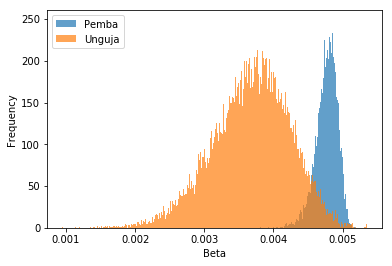

[0.00477035 0.00367984 0.00542825] [0.00442496 0.00250499 0.0051583 ] [0.00502185 0.0046769  0.00575377]


In [14]:
loc = np.array(['Pemba', 'Unguja', 'Mainland'])
num_bins = 500

for i in range(2):
    plt.hist(beta_vals[:,i], num_bins, label=loc[i], alpha=0.7)

plt.xlabel("Beta")
plt.ylabel("Frequency")
plt.legend(loc=0)
plt.savefig("../figures/beta_estimates.png")
plt.show()

beta_mean = np.mean(beta_vals, axis=0)
beta_sd = np.std(beta_vals, axis=0)
print(beta_mean, np.quantile(beta_vals,q=0.025, axis=0), np.quantile(beta_vals,q=0.975, axis=0))

[0.9540703  0.73596733 1.08565089] [0.03073945 0.11186435 0.05602873] [0.88499257 0.5009972  1.03166099] [1.00436985 0.93537915 1.15075325]


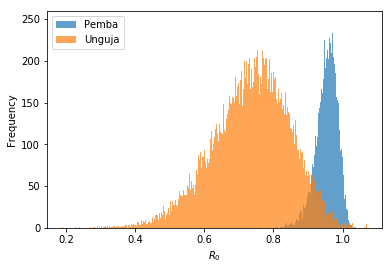

In [15]:
R0_vals = beta_vals/mu

loc = np.array(['Pemba', 'Unguja', 'Mainland'])
num_bins = 500
# plt.figure()
for i in range(2):
    plt.hist(R0_vals[:,i], num_bins, label=loc[i], alpha=0.7)

plt.xlabel("$R_0$")
plt.ylabel("Frequency")
plt.legend(loc=0)
plt.savefig("../figures/R0_estimates.png")

R0_mean = np.mean(R0_vals, axis=0)
R0_sd = np.std(R0_vals, axis=0)
print(R0_mean, R0_sd, np.quantile(R0_vals,q=0.025, axis=0), np.quantile(R0_vals,q=0.975, axis=0))

The results are summarised in the following table. $R_0$ in this context is the basic reproductive number under the condition of no movement. 

| Location | $\beta$ | $R_0$ |
|:--------:|:-------:|-------|
| Pemba    | 0.0048 \[0.0044-0.0050\]     | 0.95 \[0.88-1.00\]   |
| Unguja   | 0.0037 \[0.0025-0.0047\]     | 0.74 \[0.50-0.94\]   |
| Mainland | 0.0054 \[0.0052-0.0058\]     | 1.09 \[1.03-1.15\]   |
